## Identifying patterns in Spotify Top 50 Songs 

We aim to identify common features and characteristics of the top 50 most popular songs on Spotify 2020, a commonly used music streaming service. The dataset, provide by Spotify (https://www.kaggle.com/atillacolak/top-50-spotify-tracks-2020), includes the track names and artists of these top 50 songs along with various other descriptive features about the song and its contents (e.g., loudness, instrumentalness, danceability). By identifying common features among these songs, it may improve our understanding of the types/features of popular music and may assist future investigations for predicting individual music popularity.

Author: Jesse Huang MPH, PhD

Date created: 2023-07-10

Most recent date of modification: 2023-07-17

In [1]:
#Location of downloaded files (relative link)
file_loc = "data/spotifytoptracks.csv"

In [2]:
#Importing libraries
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

<h1> Step 1. Importing and preprocessing data </h1>

<h2>1.1. Importing dataset</h2>

In [3]:
#Importing Spotify Top Track dataset (csv). Accessed from Kaggle (2023-07-09).
raw_dt = pd.read_csv(file_loc,index_col=0)
raw_dt.head()

,artist,album,track_name,track_id,energy,danceability,key,loudness,acousticness,speechiness,instrumentalness,liveness,valence,tempo,duration_ms,genre
0,The Weeknd,After Hours,Blinding Lights,0VjIjW4GlUZAMYd2vXMi3b,0.730,0.514,1,-5.934,0.00146,0.0598,0.000095,0.0897,0.334,171.005,200040,R&B/Soul
1,Tones And I,Dance Monkey,Dance Monkey,1rgnBhdG2JDFTbYkYRZAku,0.593,0.825,6,-6.401,0.68800,0.0988,0.000161,0.1700,0.540,98.078,209755,Alternative/Indie
2,Roddy Ricch,Please Excuse Me For Being Antisocial,The Box,0nbXyq5TXYPCO7pr3N8S4I,0.586,0.896,10,-6.687,0.10400,0.0559,0.000000,0.7900,0.642,116.971,196653,Hip-Hop/Rap
3,SAINt JHN,Roses (Imanbek Remix),Roses - Imanbek Remix,2Wo6QQD1KMDWeFkkjLqwx5,0.721,0.785,8,-5.457,0.01490,0.0506,0.004320,0.2850,0.894,121.962,176219,Dance/Electronic
4,Dua Lipa,Future Nostalgia,Don't Start Now,3PfIrDoz19wz7qK7tYeu62,0.793,0.793,11,-4.521,0.01230,0.0830,0.000000,0.0951,0.679,123.950,183290,Nu-disco


In [4]:
#Basic info on data columns (n=16) for 50 row/entries
raw_dt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50 entries, 0 to 49
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artist            50 non-null     object 
 1   album             50 non-null     object 
 2   track_name        50 non-null     object 
 3   track_id          50 non-null     object 
 4   energy            50 non-null     float64
 5   danceability      50 non-null     float64
 6   key               50 non-null     int64  
 7   loudness          50 non-null     float64
 8   acousticness      50 non-null     float64
 9   speechiness       50 non-null     float64
 10  instrumentalness  50 non-null     float64
 11  liveness          50 non-null     float64
 12  valence           50 non-null     float64
 13  tempo             50 non-null     float64
 14  duration_ms       50 non-null     int64  
 15  genre             50 non-null     object 
dtypes: float64(9), int64(2), object(5)
memory usag

<h3>Notes of data prior to preprocessing</h3>

1. The dataset contains 50 observations (rows) and 16 features/variables (columns).
2. Of the 16 variables, 11 are numeric (9 float, 2 int) variables.
3. There are 5 variables that are non-numeric, of which "track_name" and "track_id" (unique) are used as identifiers.
4. Two variables "artist" and "album" are group related identifiers. "genre" is a categorical descriptor variable.


<h2>1.2. Handling Missing and Duplicate data</h2>

In [5]:
#Check for NA and duplicates in dataset, by Track name and ID
#Track Id should be an NON-EMPTY and unique identifier, as partly so with track name (although this may not be enforced)
stat_hold = {}
stat_hold['nrow'] = raw_dt.shape[0]
stat_hold['id_sz'] = raw_dt['track_id'].unique().size
stat_hold['id_na'] = raw_dt['track_id'].isna().sum()
stat_hold['name_sz'] = raw_dt['track_name'].unique().size
stat_hold['name_na'] = raw_dt['track_name'].isna().sum()

print(f"[data] Total # rows       | {stat_hold['nrow']}")
print(f"[Track ID] # of uniques   | {stat_hold['id_sz']}")
print(f"[Track ID] Number of NA   | {stat_hold['id_na']}")
print(f"[Track Name] # of uniques | {stat_hold['name_sz']}")
print(f"[Track Name] Number of NA | {stat_hold['name_na']}")

[data] Total # rows       | 50
[Track ID] # of uniques   | 50
[Track ID] Number of NA   | 0
[Track Name] # of uniques | 50
[Track Name] Number of NA | 0


In [6]:
#Check for NAs through entire dataset
raw_dt.isna().sum()

artist              0
album               0
track_name          0
track_id            0
energy              0
danceability        0
key                 0
loudness            0
acousticness        0
speechiness         0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
genre               0
dtype: int64

<h3>Notes regarding NA values and duplicates</h3>

1. There are no empty values and duplicate entries.

<h2>1.3. Examining for outliers in data</h2>

In [7]:
#Overview of statistics for numeric variables
raw_dt.describe()
#possible outliers with variables: acousticness, speechiness, instrumentalness, liveness

,energy,danceability,key,loudness,acousticness,speechiness,instrumentalness,liveness,valence,tempo,duration_ms
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,0.609300,0.716720,5.720000,-6.225900,0.256206,0.124158,0.015962,0.196552,0.555710,119.690460,199955.360000
std,0.154348,0.124975,3.709007,2.349744,0.265250,0.116836,0.094312,0.176610,0.216386,25.414778,33996.122488
min,0.225000,0.351000,0.000000,-14.454000,0.001460,0.029000,0.000000,0.057400,0.060500,75.801000,140526.000000
25%,0.494000,0.672500,2.000000,-7.552500,0.052800,0.048325,0.000000,0.093950,0.434000,99.557250,175845.500000
50%,0.597000,0.746000,6.500000,-5.991500,0.188500,0.070050,0.000000,0.111000,0.560000,116.969000,197853.500000
75%,0.729750,0.794500,8.750000,-4.285500,0.298750,0.155500,0.000020,0.271250,0.726250,132.317000,215064.000000
max,0.855000,0.935000,11.000000,-3.280000,0.934000,0.487000,0.657000,0.792000,0.925000,180.067000,312820.000000


In [8]:
num_extract = raw_dt.select_dtypes(include=np.number)
num_extract = (num_extract - num_extract.mean()) / num_extract.std()
num_extract.describe().round(2)

,energy,danceability,key,loudness,acousticness,speechiness,instrumentalness,liveness,valence,tempo,duration_ms
count,50.00,50.00,50.00,50.00,50.00,50.00,50.00,50.00,50.00,50.00,50.00
mean,0.00,-0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,0.00,0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-2.49,-2.93,-1.54,-3.50,-0.96,-0.81,-0.17,-0.79,-2.29,-1.73,-1.75
25%,-0.75,-0.35,-1.00,-0.56,-0.77,-0.65,-0.17,-0.58,-0.56,-0.79,-0.71
50%,-0.08,0.23,0.21,0.10,-0.26,-0.46,-0.17,-0.48,0.02,-0.11,-0.06
75%,0.78,0.62,0.82,0.83,0.16,0.27,-0.17,0.42,0.79,0.50,0.44
max,1.59,1.75,1.42,1.25,2.56,3.11,6.80,3.37,1.71,2.38,3.32


In [9]:
pca_model = PCA(n_components=11)
pca_data = pca_model.fit_transform(num_extract)
pca_data = pd.DataFrame(pca_data)
pca_data.head()

,0,1,2,3,4,5,6,7,8,9,10
0,-0.213450,-0.050398,-1.721015,-1.651792,-1.811018,1.340369,0.570070,0.049937,-0.165396,-0.594881,-0.317336
1,0.680649,-0.121771,0.132072,0.925720,0.860785,-0.207648,-0.622363,-0.257055,0.499817,1.004455,-0.695421
2,-0.860219,-0.751254,3.045194,-1.141689,0.484087,-1.163109,0.578409,-0.937655,0.886342,0.368193,0.133596
3,-1.668348,-0.672889,1.128252,0.580624,0.019564,0.266718,0.500161,-0.387797,-0.300118,-0.571503,0.042273
4,-1.851514,-0.263137,0.773873,0.389136,0.174938,0.858509,-0.161414,0.963000,-0.502146,-0.105459,-0.176959


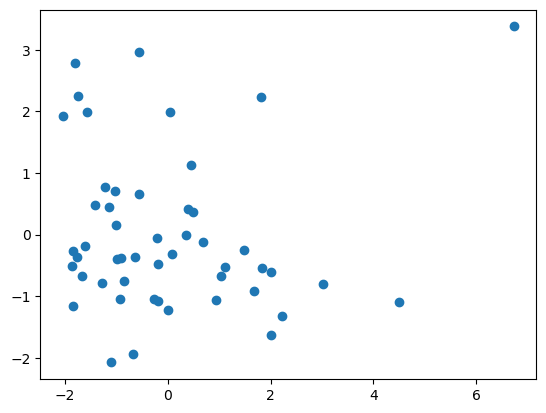

In [10]:
plt.scatter(pca_data[0],pca_data[1])

In [11]:
pca_data.sort_values(0).tail()

,0,1,2,3,4,5,6,7,8,9,10
36,2.006695,-1.635317,0.017550,-0.852736,0.104869,-0.760353,0.133699,2.112188,0.607879,-0.593121,0.491070
9,2.228031,-1.330442,-1.613309,0.335525,-0.337002,0.402058,-0.665006,-0.925896,-0.097851,0.417665,0.526316
47,3.022662,-0.796073,-1.666271,0.757149,1.062542,-0.813119,-0.554527,-1.123575,-0.594963,-0.771036,-0.646428
44,4.502733,-1.094692,-1.367290,-0.955031,-0.299839,0.474920,-1.535067,-0.284162,-0.243648,-0.316741,-0.202438
24,6.731419,3.377319,1.822173,0.560518,1.197939,1.937821,2.919560,0.163530,-0.589857,0.569267,0.154993


In [12]:
raw_dt.iloc[24,:]

artist                       Billie Eilish
album                  everything i wanted
track_name             everything i wanted
track_id            3ZCTVFBt2Brf31RLEnCkWJ
energy                               0.225
danceability                         0.704
key                                      6
loudness                           -14.454
acousticness                         0.902
speechiness                         0.0994
instrumentalness                     0.657
liveness                             0.106
valence                              0.243
tempo                              120.006
duration_ms                         245426
genre                                  Pop
Name: 24, dtype: object

In [13]:
#Create a copy of the post-processing data (although no change was made)
prp_songs = raw_dt.copy()

<h3>Notes regarding Outliers</h3>

Although there may be some outliers for the measures (acousticness, speechiness, instrumentalness, liveness), considering the exploratory and descriptive nature of this study, we will not exclude any observations in this dataset.

<h1>Step 2. Data analysis</h1>

<h2>2.1. Characterizing the artists and albums in the top 50 tracks of 2020</h2>

- Determine how many artists have more than one popular track?
- Determine how many ALBUMS have more than one popular track?

In [14]:
#Determining artist popularity by frequency among top 50
prp_songs['artist'].value_counts().head(10)

Billie Eilish    3
Dua Lipa         3
Travis Scott     3
Justin Bieber    2
Harry Styles     2
Lewis Capaldi    2
Post Malone      2
Cardi B          1
Surfaces         1
Eminem           1
Name: artist, dtype: int64

In [15]:
#number of unique artists in top 50
prp_songs['artist'].nunique()

40

In [16]:
# Determine artist popularity by frequency weighted (exponentially, ~appox downloads)

# First, determine individual popularity, ranked weighted exponentially.
# Weighted value model (value = a*b^{rank}). Determine "a" and "b" with two approximation points Rank 1 and Rank 50
# Rank 1 at 3.691 (billion) streams
# Rank 50 at 1.880 (billion) streams
# b= (3.691 / 1.880) ** (1/(1-50)) = 0.986326473309132 = 0.9863
# a= 3.691 / (0.9863 ** (1)) = 3.691 / 0.9863 = 3.7422690864848422 = 3.7423

#Reverse test Rank 1 and 50
3.7423 * (0.9863 ** 1), 3.7423 * (0.9863 ** 50)

(3.69103049, 1.8775445721993733)

In [17]:
#continued...
prp_songs['rank_weighted'] = 3.7423 * (0.9863 ** (prp_songs.index + 1))
prp_songs['rank_weighted'].head()

0    3.691030
1    3.640463
2    3.590589
3    3.541398
4    3.492881
Name: rank_weighted, dtype: float64

In [18]:
#continued...
prp_songs.groupby('artist')['rank_weighted'].sum().sort_values(ascending=False).head(10)

artist
Dua Lipa         7.803237
Billie Eilish    7.240931
Travis Scott     6.249605
Lewis Capaldi    6.220088
Harry Styles     6.160554
Justin Bieber    5.482967
Post Malone      5.343474
The Weeknd       3.691030
Tones And I      3.640463
Roddy Ricch      3.590589
Name: rank_weighted, dtype: float64

In [19]:
#Songs of the most popular artist (weighted rank)
prp_songs[prp_songs['artist']=="Dua Lipa"]

,artist,album,track_name,track_id,energy,danceability,key,loudness,acousticness,speechiness,instrumentalness,liveness,valence,tempo,duration_ms,genre,rank_weighted
4,Dua Lipa,Future Nostalgia,Don't Start Now,3PfIrDoz19wz7qK7tYeu62,0.793,0.793,11,-4.521,0.0123,0.0830,0.000000,0.0951,0.679,123.950,183290,Nu-disco,3.492881
31,Dua Lipa,Future Nostalgia,Break My Heart,017PF4Q3l4DBUiWoXk4OWT,0.729,0.730,4,-3.434,0.1670,0.0883,0.000001,0.3490,0.467,113.013,221820,Dance-pop/Disco,2.406732
48,Dua Lipa,Future Nostalgia,Physical,3AzjcOeAmA57TIOr9zF1ZW,0.844,0.647,0,-3.756,0.0137,0.0457,0.000658,0.1020,0.746,146.967,193829,Dance/Electronic,1.903624


In [20]:
# Determining album popularity by frequency among top 50
prp_songs['album'].value_counts().head(5)

Future Nostalgia        3
Hollywood's Bleeding    2
Fine Line               2
Changes                 2
Ride It                 1
Name: album, dtype: int64

In [21]:
# Number of unique album in top 50
prp_songs['album'].nunique()

45

In [22]:
# Determine album popularity by frequency weighted (exponential)
prp_songs.groupby('album')['rank_weighted'].sum().sort_values(ascending=False).head(5)

album
Future Nostalgia        7.803237
Fine Line               6.160554
Changes                 5.482967
Hollywood's Bleeding    5.343474
After Hours             3.691030
Name: rank_weighted, dtype: float64

<h3>Summary of findings</h3>

1. There are 40 unique artists on the top 50.
2. Several artists have multiple tracks on the top 50, including: {artist (# tracks)}  Billie Eilish (3), Dua Lipa (3), Travis Scott (3), Justin Bieber (2), Harry Styles (2), Lewis Capaldi (2), Post Malone (2).
3. The most popular artist by frequency is Billie Eilish, Dua Lipa, Travis Scott. However, frequency weighted by rank and stream number suggests top spot is Dua Lipa followed by Billie Eilish and Travis Scott.

1. There are 45 unique albums on the top 50.
2. These albums have multiple tracks: Future Nostalgia (3), Hollywood's Bleeding (2), Fine Line (2), Changes (2).
3. The most popular album is likely Future Nostalgia both by frequency and weighted rank.

In summary, there are several artists and albums with multiple popular songs in the top 50, suggesting possible influence from fanbase and repeatability of popular or talented artists.

<h2>2.2. Finding tracks with unique/extreme features (e.g., danceability, loudness, and duration)</h2>

- How many tracks have danceability score above 0.7 or below 0.4?
- How many tracks have loudness above -5 and below -8?
- What is the distribution of track duration? (shortest/longest track)

Danceability < 0.4: 1
Danceability > 0.7: 32


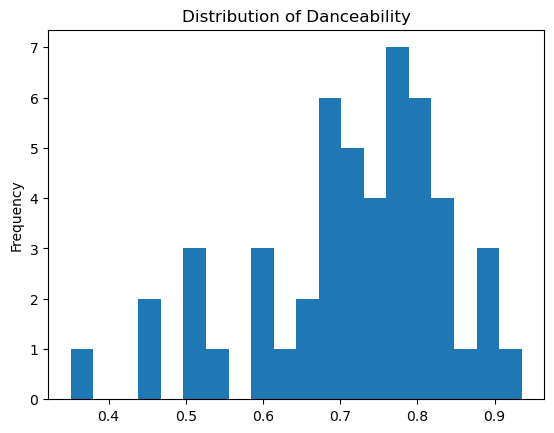

In [23]:
#Distribution of danceability scores
prp_songs['danceability'].plot(kind='hist',bins=20, xlabel='Danceability', title="Distribution of Danceability")
print(f"Danceability < 0.4: {(prp_songs['danceability']<0.4).sum()}")
print(f"Danceability > 0.7: {(prp_songs['danceability']>0.7).sum()}")

In [24]:
#Print out which songs these are.
print(prp_songs[prp_songs['danceability']<0.4]['track_name'])
print(" ")
print(prp_songs[prp_songs['danceability']>0.7]['track_name'])

44    lovely (with Khalid)
Name: track_name, dtype: object
 
1                                      Dance Monkey
2                                           The Box
3                             Roses - Imanbek Remix
4                                   Don't Start Now
5                      ROCKSTAR (feat. Roddy Ricch)
7                  death bed (coffee for your head)
8                                           Falling
10                                             Tusa
13                                  Blueberry Faygo
14                         Intentions (feat. Quavo)
15                                     Toosie Slide
17                                           Say So
18                                         Memories
19                       Life Is Good (feat. Drake)
20                 Savage Love (Laxed - Siren Beat)
22                                      Breaking Me
24                              everything i wanted
25                                         Señorita
26 

Loudness < -8: 9
Loudness > -5: 19


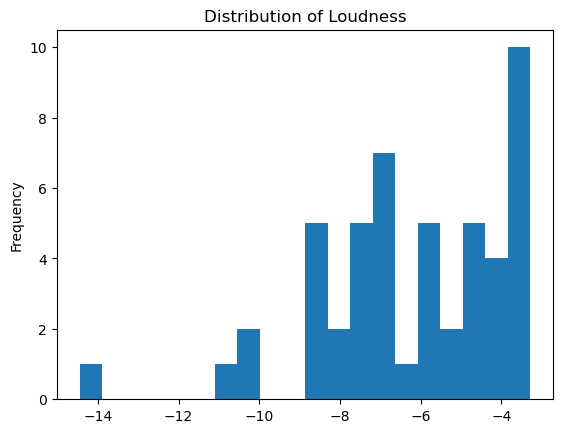

In [25]:
#Distribution of loudness scores
prp_songs['loudness'].plot(kind='hist',bins=20, xlabel='Loudness', title="Distribution of Loudness")
print(f"Loudness < -8: {(prp_songs['loudness']<-8).sum()}")
print(f"Loudness > -5: {(prp_songs['loudness']>-5).sum()}")

In [26]:
#Print out which songs these are.
print(prp_songs[prp_songs['loudness']<-8]['track_name'])
print(" ")
print(prp_songs[prp_songs['loudness']>-5]['track_name'])

7                   death bed (coffee for your head)
8                                            Falling
15                                      Toosie Slide
20                  Savage Love (Laxed - Siren Beat)
24                               everything i wanted
26                                           bad guy
36                               HIGHEST IN THE ROOM
44                              lovely (with Khalid)
47    If the World Was Ending - feat. Julia Michaels
Name: track_name, dtype: object
 
4                                   Don't Start Now
6                                  Watermelon Sugar
10                                             Tusa
12                                          Circles
16                                    Before You Go
17                                           Say So
21                                        Adore You
23                           Mood (feat. iann dior)
31                                   Break My Heart
32                   

<Axes: title={'center': 'Distribution of duration'}, ylabel='Frequency'>

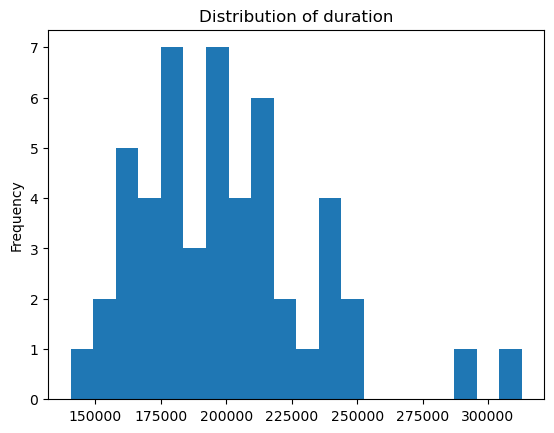

In [27]:
#Distribution of duration
prp_songs['duration_ms'].plot(kind='hist',bins=20, xlabel='Duration', title="Distribution of duration")

In [28]:
#Longest and shortest songs
prp_songs.sort_values('duration_ms').iloc[[0,-1],:]

,artist,album,track_name,track_id,energy,danceability,key,loudness,acousticness,speechiness,instrumentalness,liveness,valence,tempo,duration_ms,genre,rank_weighted
23,24kGoldn,Mood (feat. iann dior),Mood (feat. iann dior),3tjFYV6RSFtuktYl3ZtYcq,0.722,0.700,7,-3.558,0.22100,0.0369,0.0,0.272,0.756,90.989,140526,Pop rap,2.687543
49,Travis Scott,ASTROWORLD,SICKO MODE,2xLMifQCjDGFmkHkpNLD9h,0.730,0.834,8,-3.714,0.00513,0.2220,0.0,0.124,0.446,155.008,312820,Hip-Hop/Rap,1.877545


<h3>Summary of findings</h3>

1. There are 1 and 32 songs with a danceability <0.4 and >0.7, respectively. (songs listed above).
2. There are 9 and 19 songs with a loudness <-8 and >-5, respectively. (songs listed above)
3. The shortest and longest songs are Mood (feat. iann dior) (140 seconds) and SICKO MODE (313 seconds), respectively.

There is a general left-skewedness to the distributions of danceability and loudness suggesting that most popular songs are loud and danceable, with relatively few that are either quiet or undanceable. Lastly, most songs in the top 50 are well-distributed around 150 to 225 seconds in duration.

<h2>2.3. Popularity of different genres and comparing their music scores</h2>

- What are the most popular genres in the top 50 songs?
- How does danceability, loudness, acoustics compare between Pop, Hip-Hop/Rap, Dance/Electronic, and Alternative/Indie genres?


In [29]:
prp_songs['genre'].value_counts()

Pop                                   14
Hip-Hop/Rap                           13
Dance/Electronic                       5
Alternative/Indie                      4
R&B/Soul                               2
 Electro-pop                           2
Nu-disco                               1
R&B/Hip-Hop alternative                1
Pop/Soft Rock                          1
Pop rap                                1
Hip-Hop/Trap                           1
Dance-pop/Disco                        1
Disco-pop                              1
Dreampop/Hip-Hop/R&B                   1
Alternative/reggaeton/experimental     1
Chamber pop                            1
Name: genre, dtype: int64

In [30]:
prp_songs_sub = prp_songs[prp_songs['genre'].isin(['Pop','Hip-Hop/Rap','Dance/Electronic','Alternative/Indie'])]

In [31]:
#Danceability score 
#prp_songs_sub.groupby('genre')[['danceability','loudness','acousticness']].describe()
prp_songs_sub.groupby('genre')[['danceability','loudness','acousticness']].agg([np.mean,np.std,np.median])

danceability                   loudness                    \
                          mean       std median      mean       std  median   
genre                                                                         
Alternative/Indie     0.661750  0.211107  0.663 -5.421000  0.774502 -5.2685   
Dance/Electronic      0.755000  0.094744  0.785 -5.338000  1.479047 -5.4570   
Hip-Hop/Rap           0.765538  0.085470  0.774 -6.917846  1.891808 -7.6480   
Pop                   0.677571  0.109853  0.690 -6.460357  3.014281 -6.6445   

                  acousticness                    
                          mean       std  median  
genre                                             
Alternative/Indie     0.583500  0.204086  0.6460  
Dance/Electronic      0.099440  0.095828  0.0686  
Hip-Hop/Rap           0.188741  0.186396  0.1450  
Pop                   0.323843  0.318142  0.2590

<Axes: title={'center': 'acousticness'}, xlabel='genre'>

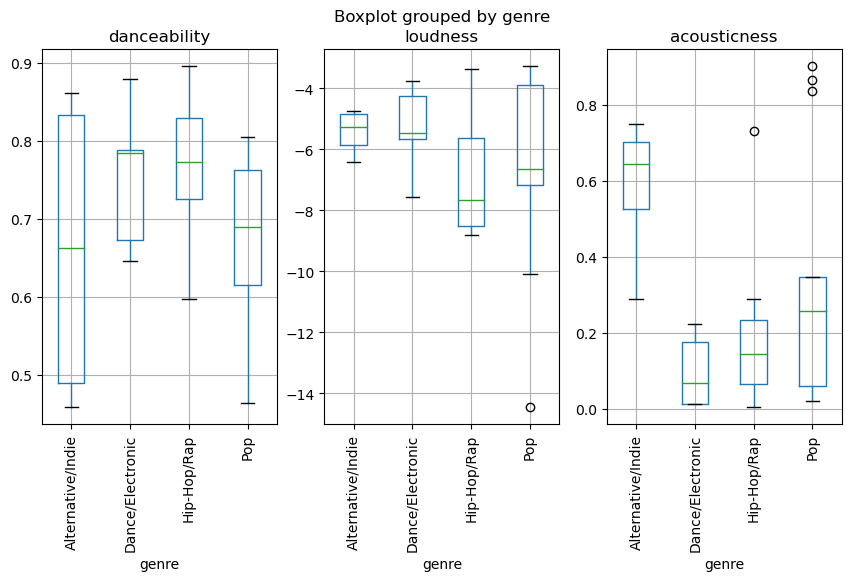

In [32]:
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
prp_songs_sub.boxplot('danceability','genre',rot=90,ax=ax[0])
prp_songs_sub.boxplot('loudness','genre',rot=90,ax=ax[1])
prp_songs_sub.boxplot('acousticness','genre',rot=90,ax=ax[2])

<h3>Summary of findings</h3>

1. The two most popular genres are Pop and Hip-Hop/Rap, respectively.
2. Although 16 unique genres are in the top 50, most have just one song in the top 50 (see list above).
3. Danceability: Dance/electronic and Hip/Hop/rap have a higher distribution for danceability. Alternative music tends to be difficult to predict with wide variability. 
4. Loudness: The distributions of loudness was fairly similar between the genres. However, alternative and dance/electronic showed a slightly higher distribution for loudness.
5. Acousticness: Alternative shows the highest distribution while certain outlier songs in Pop and hip-hop/rap show similarly high values. Dance/electronic showed the lowest distribution for acousticness.

Although there are certain trends when it comes to these characteristics beween assessed genres, the sample size is far too small to determine significance. Therefore, additional data is require to better profile songs regarding the music scores.

<h2>2.4. Correlation between features</h2>

Check if there any correlation between features.

In [33]:
corr = prp_songs.corr(numeric_only=True)
corr

,energy,danceability,key,loudness,acousticness,speechiness,instrumentalness,liveness,valence,tempo,duration_ms,rank_weighted
energy,1.000000,0.152552,0.062428,0.791640,-0.682479,0.074267,-0.385515,0.069487,0.393453,0.075191,0.081971,-0.014785
danceability,0.152552,1.000000,0.285036,0.167147,-0.359135,0.226148,-0.017706,-0.006648,0.479953,0.168956,-0.033763,0.152800
key,0.062428,0.285036,1.000000,-0.009178,-0.113394,-0.094965,0.020802,0.278672,0.120007,0.080475,-0.003345,0.045827
loudness,0.791640,0.167147,-0.009178,1.000000,-0.498695,-0.021693,-0.553735,-0.069939,0.406772,0.102097,0.064130,-0.029218
acousticness,-0.682479,-0.359135,-0.113394,-0.498695,1.000000,-0.135392,0.352184,-0.128384,-0.243192,-0.241119,-0.010988,0.035918
speechiness,0.074267,0.226148,-0.094965,-0.021693,-0.135392,1.000000,0.028948,-0.142957,0.053867,0.215504,0.366976,-0.109311
instrumentalness,-0.385515,-0.017706,0.020802,-0.553735,0.352184,0.028948,1.000000,-0.087034,-0.203283,0.018853,0.184709,-0.013364
liveness,0.069487,-0.006648,0.278672,-0.069939,-0.128384,-0.142957,-0.087034,1.000000,-0.033366,0.025457,-0.090188,0.081398
valence,0.393453,0.479953,0.120007,0.406772,-0.243192,0.053867,-0.203283,-0.033366,1.000000,0.045089,-0.039794,0.021687
tempo,0.075191,0.168956,0.080475,0.102097,-0.241119,0.215504,0.018853,0.025457,0.045089,1.000000,0.130328,-0.073388


<Axes: >

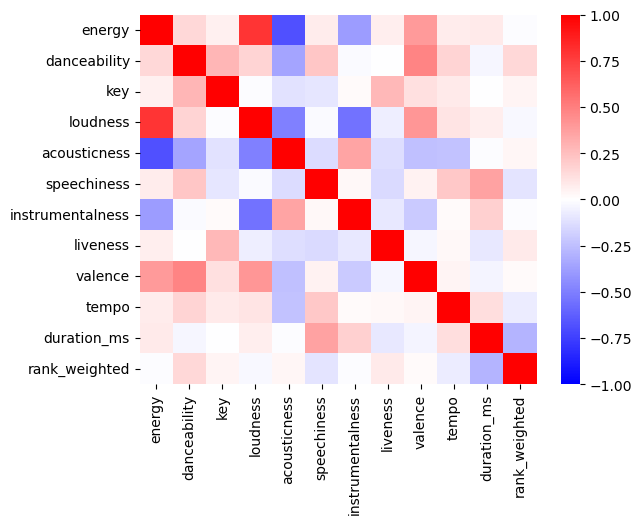

In [34]:
sns.heatmap(corr, cmap='bwr', vmin=-1, vmax=1, center=0)

<h3>Summary of findings</h3>

1. Energy is strongly correlated with loudness (positively, 0.791640) and acousticness (negatively, -0.682479).
2. Energy is minorly correlated with instrumentalness (-0.385515) and valence (0.393453).
3. Danceability has minor correlation with acousticness (-0.359135) and valence (0.479953).

In summary, songs that have lower acousticness tend to have more energy, loudness, and danceability.

## Conclusion
 There were several interesting characteristics within the top 50 songs on Spotify. Several artists and albums have multiple songs in the top 50, with the popular artist being Dua Lipa followed by Billie Eilish and Travis Scott. Although the overall distribution of certain music scores particularly danceability differed by genre, the overall limited sample size prevents us from determining any significant differences. Lastly, songs that have generally lower acoustics or more instrumental have less energy, loudness, and danceability. 

### Future investigation
One of the major issues with this analysis is the limited sample size, which limits the accuracy and reliability of our results and comparisons. This is particularly true for comparing measures between categories (e.g., genre). Therefore, I suggest using the top 100 or top 500 for more power. Lastly, to provide predictive capability and potential application in the industry, proper controls (non-popular songs) are required to determine characteristics that are specific for popular songs, which may help determine future popular songs (for sponsorship or other marketing applications.